<a href="https://colab.research.google.com/github/diogosaucedo/Praticas-de-IA/blob/main/Random_Forest_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo
Este sistema tem como objetivo a predição de tendência dentro do par de moedas EUR/USD, onde será usado uma Random Forest para classificação que irá predizer o aumento ou diminuição do preço. Tem como intuito auxiliar a confirmação de tendência de preço para compra ou venda dentro do mercado Forex.


#ETL
Esta etapa é responsável por fazer o processo de extração, transformação e carregamento dos dados.
 
## Dados
Os dados do dataframe contém uma série temporal dos preços do par de moedas EUR/USD, onde cada amostra possui informações de abertura, fechamento, máxima, mínima e volume de cada vela. Uma vela representa a oscilação de preço durante um minuto. 
 
## Intervalo de coleta
*   6 de novembro de 2020, 03:33:00 GMT-04:00
*   3 de maio de 2021 às 23:59:00 GMT-04:00




## Bibliotecas

Usaremos o **pandas** para manipulação de dados e **talib** para pegar informações de indicadores técnicos. **pickle** sera usado para serializar e desserializar uma estrutura de objeto Python.

In [ ]:
import pandas as pd
from talib.abstract import *
import pickle

In [ ]:
# load dataframe
with open("EURUSD", "rb") as f:
    inputs = pickle.load(f) # inputs é um dicionario que contém open, high, low, closed e volume
dataframe = pd.DataFrame.from_dict(inputs)

# Indicadores Técnicos
Um indicador técnico é uma ferramenta primordial de análise técnica. As decisões sobre como e quando fazer transações são baseadas em sinais de indicadores técnicos. A sua essência reside na previsão de mudanças futuras de preço, com base na conversão matemática de preço e/ou volumes de um instrumento financeiro. Com isso, você recebe uma oportunidade para identificar várias características e padrões de movimentos de preços, que não são visíveis à primeira vista.
## Bandas de bollinger
Bandas de Bollinger consistem numa linha central e duas outras (bandas) de preços acima e abaixo desta. A linha central é uma média móvel exponencial; as bandas de preços são os desvios-­padrão das ações em análise. As bandas irão se expandir e contrair de acordo com o preço da ação.
## RSI
O Relative Strength Index (RSI) é um indicador de análise técnica desenvolvido no final dos anos 70 como uma ferramenta que os traders da bolsa de valores usavam para examinar o comportamento de uma ação ao longo de determinado período específico. Ele é, basicamente, um analista de impulso que mede a magnitude das movimentações de preço além da velocidade desses movimentos. O RSI pode ser uma ferramenta muito útil dependendo do tipo de negociação que se realiza e é amplamente utilizado por muitos traders e analistas técnicos.
## EMA
A Média Móvel Exponencial é um dos indicadores básicos de análise técnica que é muito útil para os negociantes de Forex determinarem a tendência do valor de um ativo, levando em consideração seu valor médio durante um determinado período de tempo.
## CCI 
O indicador mede o nível atual de preços em relação a um nível médio, em uma determinada janela de tempo. Dessa forma, quanto mais distante da média, maior o seu valor. A técnica apresentará leituras positivas se acima da média e valores negativos se abaixo da média. Um indicador que informa ao analista o quão distante está de um valor de equilíbrio, torna-se imediatamente candidato a ser usado como um detector de sobrecompra e sobrevenda como será visto mais adiante.
## Timeperiod
Este atributo é responsável por determinar quantas amostras o indicador utilizará para fazer os cálculos. Quanto mais próximo a 1, mais flexível tende a ser o indicador, sendo que a k-ésima amostra e o k-ésimo valor calculado pelo indicador terão valores próximos, tornando-o pouco sensível à variação de preço. O mesmo se aplica a ordem inversa, valores positivos distantes de 1 tendem a tornar o indicador mais sensível a variação de preços, pois o k-ésimo valor do indicador não acompanha facilmente a k-ésima amostra.


In [ ]:
dataframe['BB_UP'], dataframe['BB_MID'], dataframe['BB_LOW'] = BBANDS(inputs, timeperiod=20, nbdevup=2.5, nbdevdn=2.5, matype=0) # Bandas de Bollinger
dataframe['EMA'] = EMA(dataframe, timeperiod=100) # Média móvel exponencial
dataframe['RSI'] = RSI(dataframe['close'], timeperiod=14) # RSI
dataframe['CCI'] = CCI(dataframe['high'], dataframe['low'], dataframe['close'], timeperiod=14) # CCI

O dataframe contém valores nulos, precisamos removê-los, ou melhor, PREENCHÊ-LOS!

In [ ]:
dataframe.fillna(method="ffill", inplace=True)  # ffill: propaga a última observação válida para a próxima válida
dataframe.fillna(method="bfill", inplace=True)  # bfill: usa a próxima observação válida para preencher a lacuna.

Gerando classes

In [ ]:
minutes = 10 # Faremos previsão para os proximos 10 minutos
temp_df = dataframe['close'].shift(-minutes) # Desloca a coluna 10 posições
temp_df.fillna(method="ffill", inplace= True)
temp_df.fillna(method="bfill", inplace= True)
# 1 = aumento de preço, 0 = diminuição de preço
classes = [1 if temp_df[i] > inputs['close'][i] else 0 for i in range(len(inputs['close']))]

## pairplot 
Nos permite observar a relação entre pares de dados. O parâmetro `hue` faz um mapeamento semântico e nos mostra uma estimativa de densidade do kernel em camadas. Neste exemplo o `hue` mapeia o campo "classes" mostrando sua distribuição de densidade, cores 'transparentes' significam baixa densidade, enquanto as cores fortes representam alta densidade.
Neste exemplo usaremos apenas 5000 amostras, para que a execução seja mais rapida.

In [ ]:
import seaborn as sns

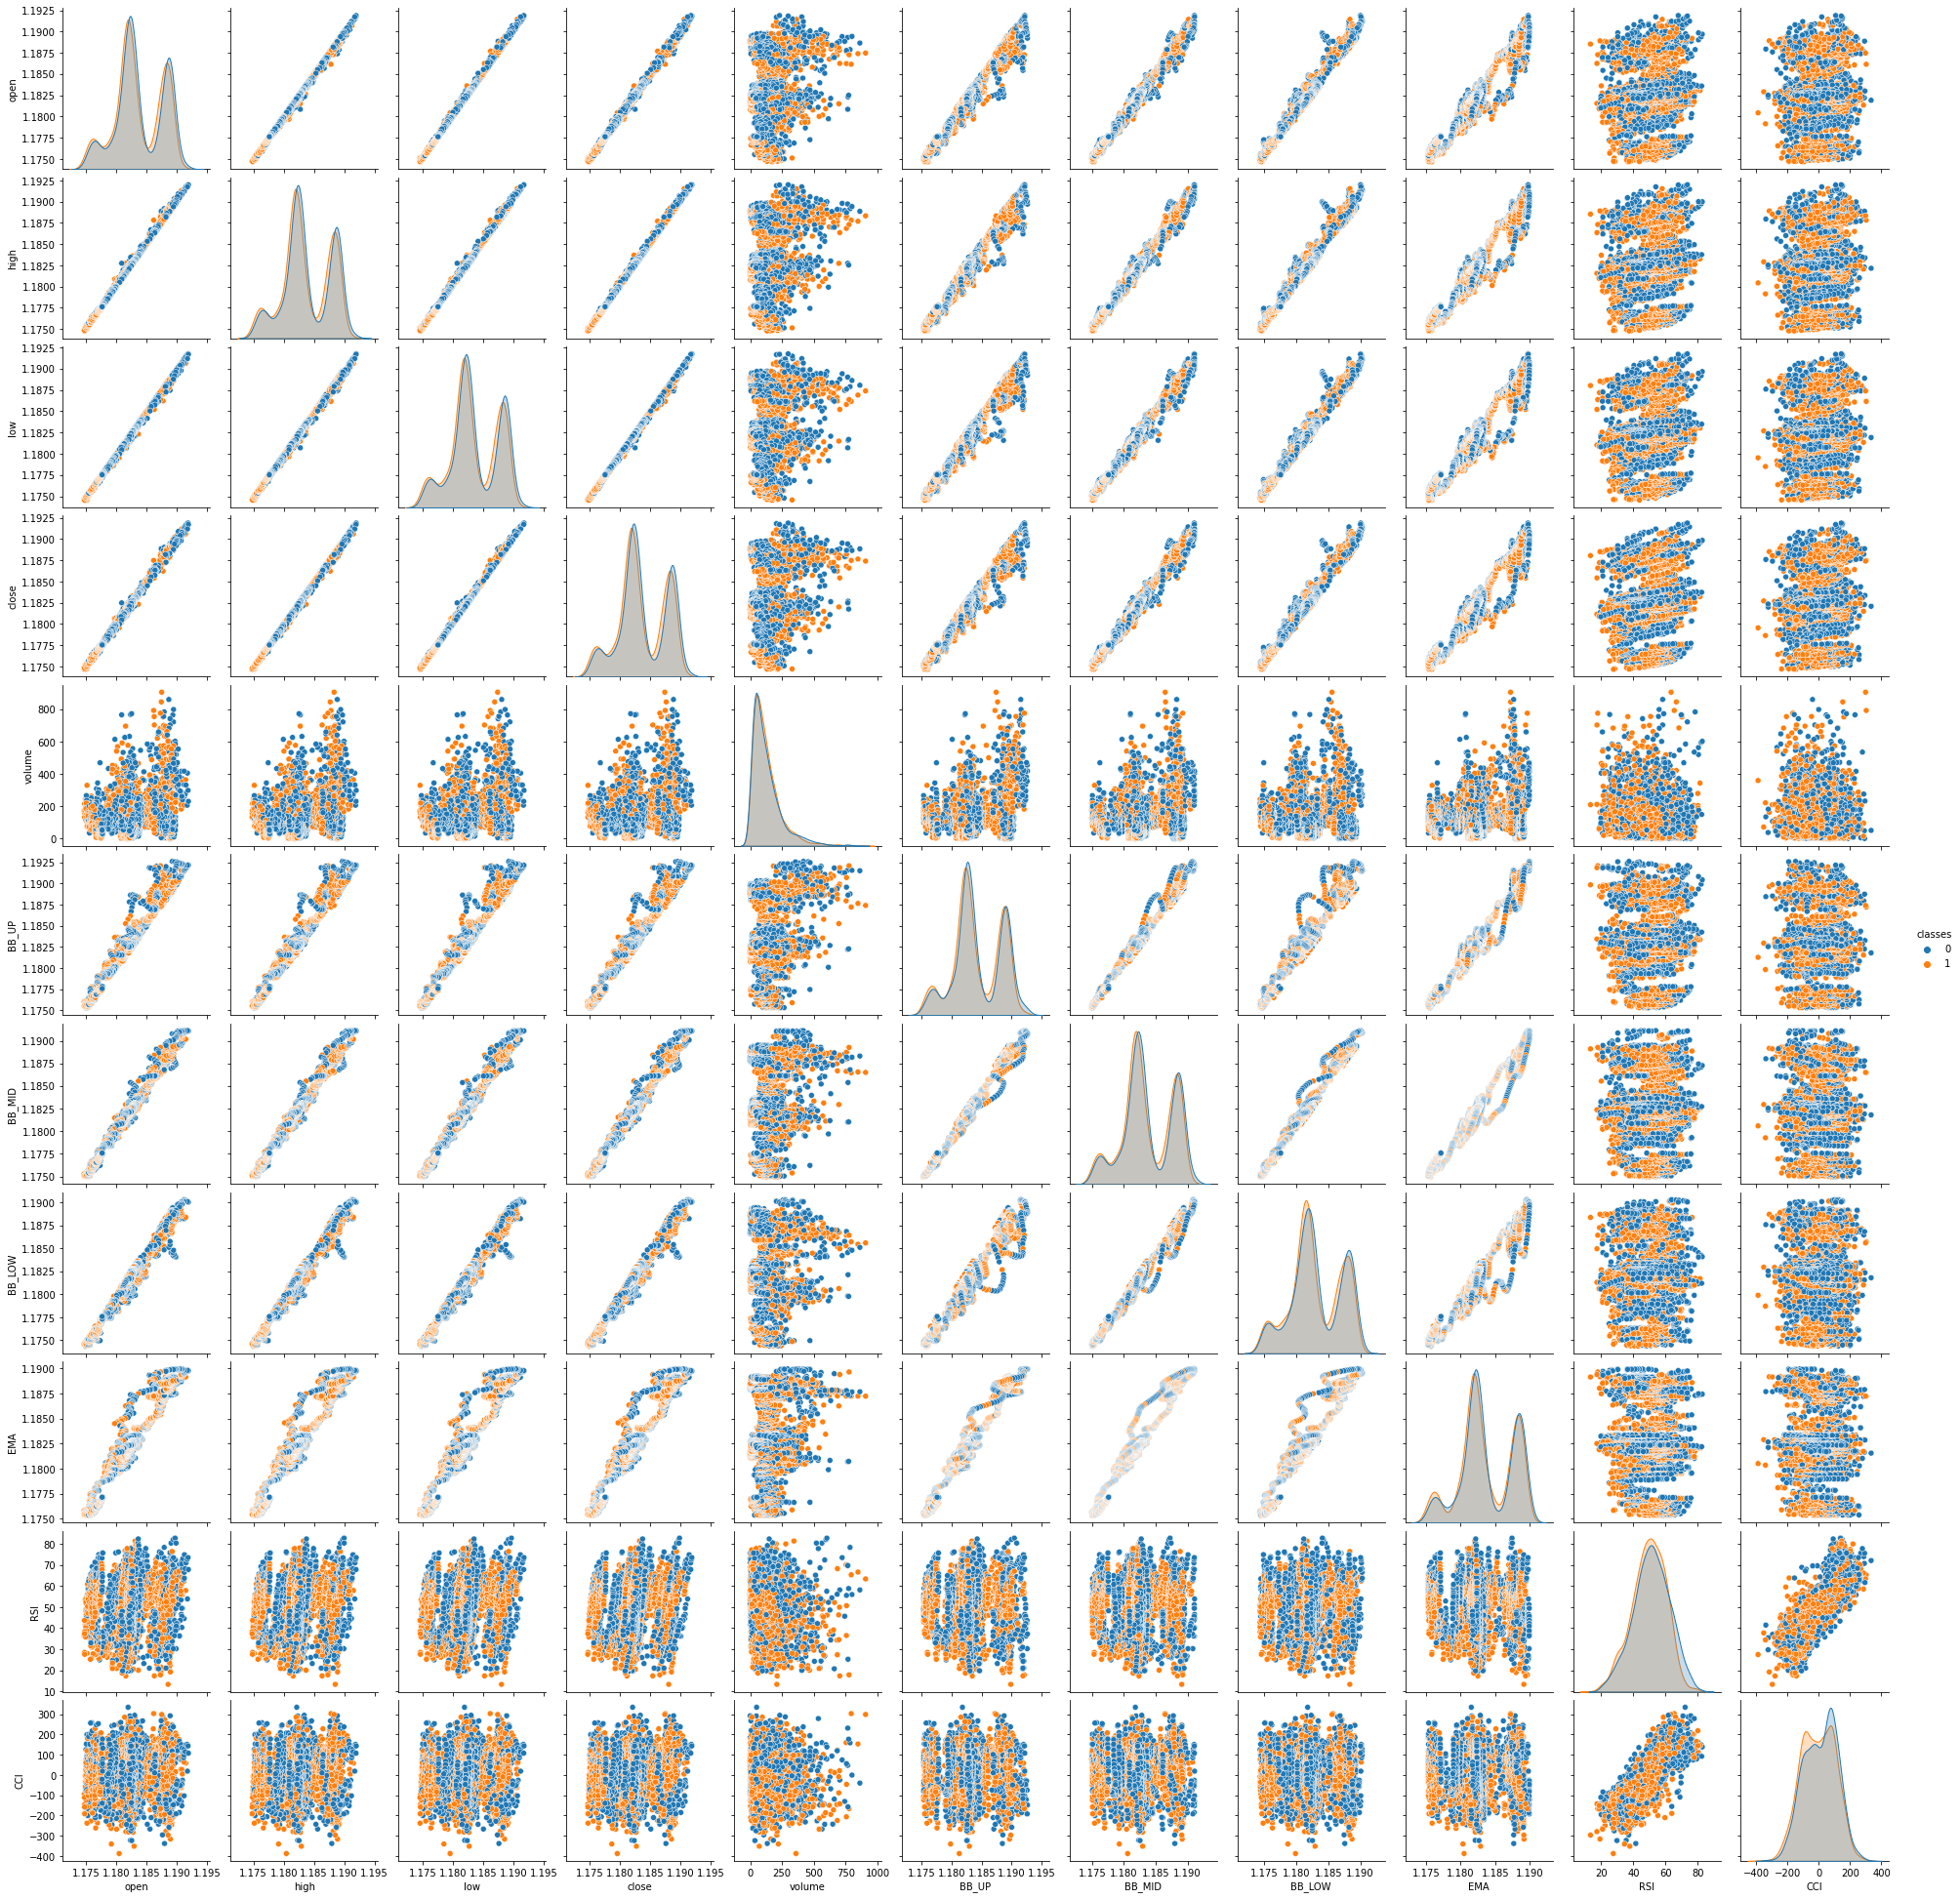

In [ ]:
dataframe['classes'] = classes
sns.pairplot(data=dataframe[:5000], hue='classes')
dataframe = dataframe.drop(columns=['classes'])

O par de  indicadores RSI e CCI nos mostram algo semelhante a uma reta em 45 graus. Quanto mais próximo a reta, maior a concentração de alta de preços, o que nos mostra que quando ambos crescem proporcionalmente, maior a probabilidade alta. Ainda no par RSI e CCI notamos que quando ambos atingem valores muito altos ou muito baixos, maior a probabilidade de baixa e alta respectivamente, esse comportamento é conhecido como reversão de tendência.

# Divisão de dados 

A divisão de dados pode ser temporal ou embaralhada, aqui foi escolhido o embaralhamento.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [ ]:
test_size = 0.2 # 20% das amostras serão utilizadas para teste
X_train,X_test,y_train,y_test=train_test_split(dataframe, classes, test_size= test_size, random_state=101)

## Distribuição de dados
Optamos pela distribuição uniforme ao invés da gaussiana

In [ ]:
scaler=QuantileTransformer()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train),columns = X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns, index=X_test.index)

## Random Forest
Random Forest (Floresta Aleatória) é um método de aprendizado conjunto para classificação e regressão que opera construindo várias árvores de decisão no momento do treinamento e produzindo a classe, que é o modo das saídas geradas por árvores individuais. O algoritmo foi desenvolvido por Leo Breiman e Adele Cutler. Sua escolha como modelo se deve a um estudo realizado por Gustavo Carvalho na UFU, onde comparou RNA, SVM e RF na previsão de tendência, onde as Random Forest se sobressaíram entre os demais algoritmos.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

Treinamento da Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

# Predição e score

## Predição e score por hold-out

In [ ]:
predictions = rf.predict(X_test)
score = rf.score(X_test, y_test)
print('Score: ', round(score,2))

Score:  0.72


## Cross-validation
O *K-fold* aqui configurado pelo parametro `cv` foi mantido em 5, que é o valor default da função `cross_val_score`.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(rf, pd.concat([X_train, X_test]), (y_train + y_test), cv=5)
print("Acurácia rf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Acurácia rf: 0.72 (+/- 0.01)


## Conclusão
O algoritmo consegue manter uma precisão acima de 70% em validação cruzada, que é responsável por fazer a generalização do modelo através da alternância da distribuição de dados entre treinamento e teste. O algoritmo deve ser usado para confirmação de uma tendência ou reversão, junto com análise técnica e/ou fundamentalista, sendo esta, feita por uma pessoa experiente no mercado.
 
### Teste em ambiente real
Em tempo real, enquanto o mercado estava aberto, notou-se a necessidade de saber a probabilidade da classificação, este valor é obtido pela função `predict_proba` dentro do objeto `rf`. A escolha e justificativa de uma porcentagem de probabilidade fica como objeto de estudo para um próximo trabalho.


## Referencia bibliografica

SANTOS, Gustavo Carvalho et al. Algoritmos de machine learning para previsão de ações da B3. 2020.

CUTLER, A.; CUTLER, D. R.; STEVENS, J. R. Random Forests. Boston,
MA: Springer US, 2012. 157-175 p. ISBN 978-1-4419-9326-7. Disponível em:
<https://doi.org/10.1007/978-1-4419-9326-7_5>.

DAI, Y.; ZHANG, Y. Machine learning in stock price trend forecasting. [S.l.]:
Stanford University Stanford, 2013.